In [ ]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_table("/content/drive/MyDrive/expression/train_master.tsv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.describe()

,id,userid,pose,expression,eyes
count,312,312,312,312,312
unique,312,20,4,4,2
top,train_0000.jpg,kawamura,up,sad,sunglasses
freq,1,23,88,83,160


In [ ]:
def make_data_list():
    df_label = pd.read_table("/content/drive/MyDrive/expression/train_master.tsv")
    list_eyes = df_label["eyes"].tolist()
    list_filepath = df_label["id"].tolist()
    list_expression = df_label["expression"].tolist()
    list_pose = df_label["pose"].tolist()
    list_userid =df_label["userid"].tolist()
    return list_filepath, list_userid,list_pose, list_expression, list_eyes

list_filepath, list_userid, list_pose, list_expression, list_eyes = make_data_list()

In [ ]:
list_eyes

['open',
 'open',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'open',
 'open',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'open',
 'open',
 'open',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'open',
 'open',
 'open',
 'sunglasses',
 'open',
 'open',
 'open',
 'sunglasses',
 'open',
 'open',
 'open',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'open',
 'open',
 'sunglasses',
 'open',
 'open',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'open',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'open',
 'open',
 'open',
 'sunglasses',
 'sunglasses',
 'open',
 'sunglasses',
 'open',
 'open',
 'sunglasses',
 'open',
 'open',
 'open',
 'sunglasses',
 

In [ ]:
def select_pose(df,pose):
  df_p = df[df["pose"]== pose]
  return df_p

In [ ]:
select_pose(df,"straight")

,id,userid,pose,expression,eyes
0,train_0000.jpg,choon,straight,angry,open
1,train_0001.jpg,kk49,straight,angry,open
5,train_0005.jpg,megak,straight,neutral,open
7,train_0007.jpg,saavik,straight,happy,sunglasses
8,train_0008.jpg,at33,straight,neutral,sunglasses
...,...,...,...,...,...
294,train_0294.jpg,an2i,straight,happy,open
296,train_0296.jpg,at33,straight,neutral,open
298,train_0298.jpg,ch4f,straight,angry,sunglasses
307,train_0307.jpg,karyadi,straight,neutral,open


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
img_test = read_image("/content/drive/MyDrive/expression/train/train_0000.jpg")
print(img_test.shape)

torch.Size([1, 120, 128])


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [ ]:
import os.path as osp

In [ ]:
import torch.utils.data as data

In [ ]:
from PIL import Image

In [ ]:
train_list_filepath, val_list_filepath, train_list_expression, val_list_expression = train_test_split(
    list_filepath,
    list_expression,
    test_size = 0.25
    )

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, l_filepath, l_expression, transform):
        self.filepath = l_filepath
        self.expression = l_expression
        self.transform = transform
    
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self, index):
        rootpath = "/content/drive/MyDrive/expression"
        img_path = osp.join(rootpath, "train", self.filepath[index])
        img = Image.open(img_path)
        img_transformed = transform(img)
        
        label = self.expression[index]
        if label == "angry":
            label = 0
        elif label == "sad":
            label = 1
        elif label == "neutral":
            label = 2
        else:
            label = 3
        
        return img_transformed, label

train_dataset = Dataset(
    l_filepath = train_list_filepath,
    l_expression = train_list_expression,
    transform = transform
)

val_dataset = Dataset(
    l_filepath = val_list_filepath,
    l_expression = val_list_expression,
    transform = transform
)

index = 9
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(val_dataset.__getitem__(index)[0].size())
print(val_dataset.__getitem__(index)[1])

torch.Size([1, 120, 128])
0
1
torch.Size([1, 120, 128])
1
2


In [ ]:
BATCH_SIZE = 10

In [ ]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0, 
    #drop_last=True,
)


test_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0, 
    #drop_last=True,
)

In [ ]:
n_input = train_dataset.__getitem__(index)[0].view(-1).shape[0]

# 出力次元数
# 分類先クラス数　
n_output = 4

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 15360  n_hidden: 128 n_output: 4


In [ ]:
def eval_loss(train_loader, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for image_transformed, labels in train_loader:
        break

    
    n_inputs = image_transformed
    labels = labels

    # 予測計算
    n_outputs = net(n_inputs)

    #  損失計算
    loss = criterion(n_outputs, labels)

    return loss

In [ ]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.conv5 = nn.Conv2d(32, 64, 3)
        self.conv6 = nn.Conv2d(64, 64, 3)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(8448, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [ ]:
lr = 0.001
net = CNN_v2(n_output)
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))
criterion = nn.CrossEntropyLoss()

In [ ]:
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()


In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for n_inputs, labels in tqdm(train_loader):
            n_inputs, labels = n_inputs, labels
            count += len(labels)
           

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            n_outputs = net(n_inputs)

            # 損失計算
            loss = criterion(n_outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(n_outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for n_inputs, labels in test_loader:
            count += len(labels)
           

            # 予測計算
            n_outputs = net(n_inputs)

            # 損失計算
            loss = criterion(n_outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(n_outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [ ]:
num_epochs = 100 
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, history)

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.14260 acc: 0.23504 val_loss: 0.14267, val_acc: 0.23504


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.14259 acc: 0.23504 val_loss: 0.14266, val_acc: 0.23504


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.14266 acc: 0.23504 val_loss: 0.14264, val_acc: 0.23504


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.14256 acc: 0.23504 val_loss: 0.14263, val_acc: 0.23504


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.14263 acc: 0.23504 val_loss: 0.14261, val_acc: 0.23504


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.14262 acc: 0.19658 val_loss: 0.14260, val_acc: 0.24786


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.14259 acc: 0.25214 val_loss: 0.14259, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.14258 acc: 0.25641 val_loss: 0.14258, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.14249 acc: 0.25641 val_loss: 0.14256, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.14262 acc: 0.25641 val_loss: 0.14255, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.14248 acc: 0.25641 val_loss: 0.14254, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.14253 acc: 0.25641 val_loss: 0.14253, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.14246 acc: 0.25641 val_loss: 0.14252, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.14258 acc: 0.25641 val_loss: 0.14251, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.14256 acc: 0.25641 val_loss: 0.14249, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.14249 acc: 0.25641 val_loss: 0.14249, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.14248 acc: 0.25641 val_loss: 0.14247, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.14253 acc: 0.25641 val_loss: 0.14246, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.14252 acc: 0.25641 val_loss: 0.14245, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.14240 acc: 0.25641 val_loss: 0.14244, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.14250 acc: 0.25641 val_loss: 0.14243, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.14239 acc: 0.25641 val_loss: 0.14242, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.14238 acc: 0.25641 val_loss: 0.14242, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.14239 acc: 0.25641 val_loss: 0.14241, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.14245 acc: 0.25641 val_loss: 0.14240, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.14253 acc: 0.25641 val_loss: 0.14239, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.14242 acc: 0.25641 val_loss: 0.14238, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.14241 acc: 0.25641 val_loss: 0.14237, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.14232 acc: 0.25641 val_loss: 0.14236, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.14231 acc: 0.25641 val_loss: 0.14236, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.14235 acc: 0.25641 val_loss: 0.14235, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.14235 acc: 0.25641 val_loss: 0.14234, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.14238 acc: 0.25641 val_loss: 0.14234, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.14234 acc: 0.25641 val_loss: 0.14233, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.14233 acc: 0.25641 val_loss: 0.14232, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.14224 acc: 0.25641 val_loss: 0.14232, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.14226 acc: 0.25641 val_loss: 0.14231, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.14228 acc: 0.25641 val_loss: 0.14230, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.14228 acc: 0.25641 val_loss: 0.14229, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.14232 acc: 0.25641 val_loss: 0.14228, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.14222 acc: 0.25641 val_loss: 0.14229, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.14227 acc: 0.25641 val_loss: 0.14228, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.14226 acc: 0.25641 val_loss: 0.14227, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.14228 acc: 0.25641 val_loss: 0.14227, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.14229 acc: 0.25641 val_loss: 0.14226, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.14223 acc: 0.25641 val_loss: 0.14226, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.14221 acc: 0.25641 val_loss: 0.14225, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.14225 acc: 0.25641 val_loss: 0.14225, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.14220 acc: 0.25641 val_loss: 0.14224, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.14223 acc: 0.25641 val_loss: 0.14224, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.14224 acc: 0.25641 val_loss: 0.14223, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.14222 acc: 0.25641 val_loss: 0.14223, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.14224 acc: 0.25641 val_loss: 0.14223, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.14223 acc: 0.25641 val_loss: 0.14222, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.14221 acc: 0.25641 val_loss: 0.14221, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.14218 acc: 0.25641 val_loss: 0.14221, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.14220 acc: 0.25641 val_loss: 0.14221, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.14221 acc: 0.25641 val_loss: 0.14220, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14220, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14220, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.14213 acc: 0.25641 val_loss: 0.14219, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.14220 acc: 0.25641 val_loss: 0.14219, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14218, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14218, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.14219 acc: 0.25641 val_loss: 0.14218, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.14212 acc: 0.25641 val_loss: 0.14217, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14217, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.14218 acc: 0.25641 val_loss: 0.14217, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.14214 acc: 0.25641 val_loss: 0.14217, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14216, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.14213 acc: 0.25641 val_loss: 0.14215, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.14208 acc: 0.25641 val_loss: 0.14215, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.14216 acc: 0.25641 val_loss: 0.14215, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.14213 acc: 0.25641 val_loss: 0.14214, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.14217 acc: 0.25641 val_loss: 0.14214, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.14214 acc: 0.25641 val_loss: 0.14214, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.14212 acc: 0.25641 val_loss: 0.14214, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.14211 acc: 0.25641 val_loss: 0.14213, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.14210 acc: 0.25641 val_loss: 0.14213, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.14210 acc: 0.25641 val_loss: 0.14213, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.14211 acc: 0.25641 val_loss: 0.14213, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.14211 acc: 0.25641 val_loss: 0.14213, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.14213 acc: 0.25641 val_loss: 0.14212, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.14211 acc: 0.25641 val_loss: 0.14212, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.14207 acc: 0.25641 val_loss: 0.14211, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.14207 acc: 0.25641 val_loss: 0.14211, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.14204 acc: 0.25641 val_loss: 0.14211, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.14206 acc: 0.25641 val_loss: 0.14211, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.14203 acc: 0.25641 val_loss: 0.14211, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.14211 acc: 0.25641 val_loss: 0.14210, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.14202 acc: 0.25641 val_loss: 0.14210, val_acc: 0.25641


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.14212 acc: 0.24359 val_loss: 0.14209, val_acc: 0.26068


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.14205 acc: 0.19658 val_loss: 0.14210, val_acc: 0.26068


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.14204 acc: 0.23077 val_loss: 0.14209, val_acc: 0.28205


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.14210 acc: 0.24786 val_loss: 0.14209, val_acc: 0.27350


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.14203 acc: 0.26923 val_loss: 0.14209, val_acc: 0.27350


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.14210 acc: 0.27350 val_loss: 0.14209, val_acc: 0.27350


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.14209 acc: 0.27350 val_loss: 0.14209, val_acc: 0.27350


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.14206 acc: 0.27350 val_loss: 0.14208, val_acc: 0.27350


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.14206 acc: 0.27350 val_loss: 0.14208, val_acc: 0.27350


In [ ]:
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.ylim(0,1)
    plt.show()

初期状態: 損失: 0.14267 精度: 0.23504
最終状態: 損失: 0.14208 精度: 0.27350


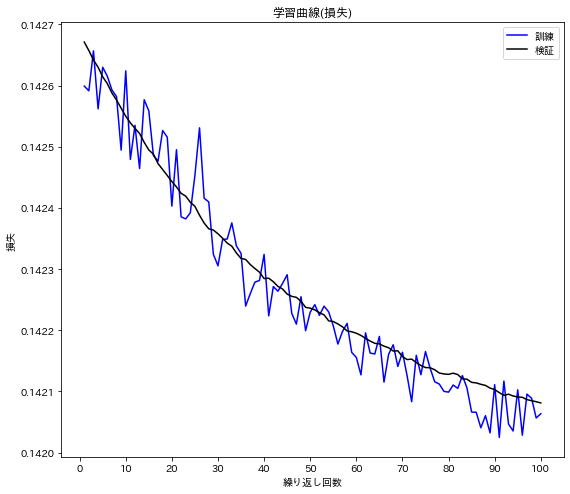

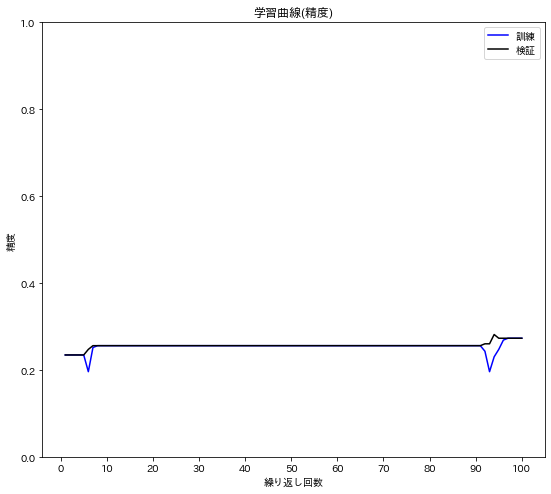

In [ ]:
evaluate_history(history)

In [ ]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
# モデルを保存する。
torch.save(net.state_dict(), "/content/drive/MyDrive/expression/net.pth")

# 保存したモデルを読み込む。
#model = torch.load("net.pth")